# Pipeline
## Cleaning confounds
We first created the confound matrix according to Smith et al. (2015). The confound variables are motion (Jenkinson), sex, and age. We also created squared confound measures to help account for potentially nonlinear effects of these confounds.
## Nested k-fold cross validation
We employed the nested approach to accomandate the hyper-parameter selection and model selection. This is a complex and costly method but the smaple size allows us to use this approach.

In [1]:
import copy
import os, sys
import numpy as np
import pandas as pd

import joblib

In [2]:
os.chdir('../')

In [3]:
# loa my modules
from src.utils import load_pkl
from src.file_io import save_output
from src.models import nested_kfold_cv_scca, clean_confound, permutate_scca
from src.visualise import set_text_size, show_results, write_pdf, write_png

In [5]:
dat_path = './data/processed/dict_SCCA_data_prepro_06092017.pkl'
# load data
dataset = load_pkl(dat_path)

dataset.keys()

['Motion_Jenkinson',
 'CognitiveMeasures_labels',
 'Gender',
 'Age',
 'Yeo17_ROIs',
 'IDs',
 'CognitiveMeasures',
 'MRIQ_labels',
 'FC_Yeo17',
 'BzdokDMN_ROIs',
 'Motion_power',
 'FC_Yeo7LiberalMask',
 'FC_Yeo7',
 'FC_BzdokDMN',
 'MRIQ',
 'Yeo7_ROIs']

In [7]:
FC_yeo17 = dataset['FC_Yeo17']
MRIQ    = dataset['MRIQ']
mot     = dataset['Motion_Jenkinson']
sex     = dataset['Gender']
age     = dataset['Age']
confound_raw = np.hstack((mot, sex, age))

In [9]:
out_folds = 5
in_folds = 5
n_selected = 4

## confound cleaning in CV loops

Fold 1/5


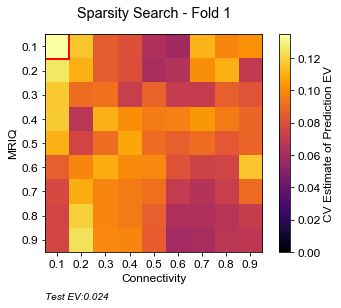


New Best model: 
 4 components,penalty x: 0.1, penalty y: 0.1
OOS performance: 0.0243757690976
Fold 2/5


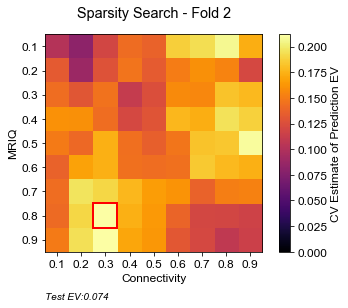


New Best model: 
 4 components,penalty x: 0.3, penalty y: 0.8
OOS performance: 0.0741043343678
Fold 3/5


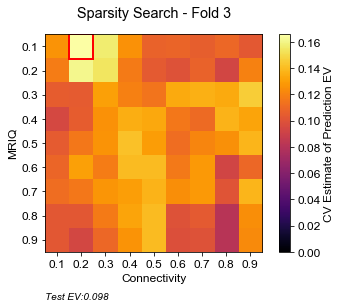


New Best model: 
 4 components,penalty x: 0.2, penalty y: 0.1
OOS performance: 0.0982333579287
Fold 4/5


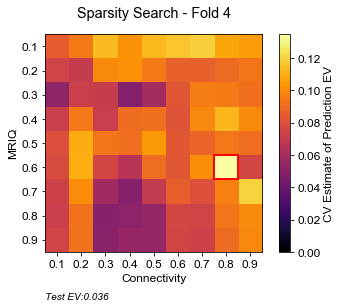

Fold 5/5


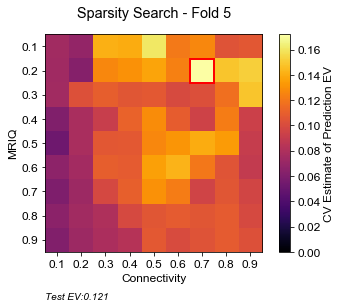


New Best model: 
 4 components,penalty x: 0.7, penalty y: 0.2
OOS performance: 0.121409305021

Best parameters based on outer fold ev results: X-0.7; Y-0.2

CPU times: user 5min 27s, sys: 7min 12s, total: 12min 40s
Wall time: 4min 24s


In [11]:
%%time
para_search, best_model, pred_errors = nested_kfold_cv_scca(
    FC_yeo17, MRIQ, R=confound_raw, n_selected=n_selected, 
    out_folds=5, in_folds=5, 
    reg_X=(0.1, 0.9), reg_Y=(0.1, 0.9)
)

In [13]:
u, v = best_model.u, best_model.v

set_text_size(12)
figs = show_results(u, v, dataset['Yeo17_ROIs'], dataset['MRIQ_labels'], rank_v=True, sparse=True)
write_png('./reports/revision/bestModel_yeo17_component_{:}.png', figs)
X, Y, R = clean_confound(FC_yeo17, MRIQ, confound_raw)
X_scores, Y_scores, df_z = save_output(dataset, confound_raw, best_model, X, Y, path=None)

df_z.to_csv('./data/processed/NYCQ_CCA_score_revision_yeo17_{0:1d}_{1:.1f}_{2:.1f}.csv'.format(
            best_model.n_components, best_model.penX, best_model.penY))
df_z.to_pickle('./data/processed/NYCQ_CCA_score_revision_yeo17_{0:1d}_{1:.1f}_{2:.1f}.pkl'.format(
            best_model.n_components, best_model.penX, best_model.penY))

joblib.dump(best_model, 
            './models/SCCA_Yeo17_revision_{:1d}_{:.2f}_{:.2f}.pkl'.format(
                best_model.n_components, best_model.penX, best_model.penY))

['./models/SCCA_Yeo17_revision_4_0.70_0.20.pkl']

In [14]:
df_permute = permutate_scca(X, Y, best_model.cancorr_, best_model, n_permute=1000)
df_permute

,P-values,alpah0.001,alpah0.01,alpah0.05
Component,,,,
1,0.925,False,False,False
2,0.001,False,True,True
3,0.976,False,False,False
4,0.874,False,False,False
